<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº5
#### Nicolás Sewrjugin y Sofía Gervasi


# Introducción

En el procesamiento digital de señales, la densidad espectral de potencia (*PSD*) es una herramienta fundamental para caracterizar cómo se distribuye la potencia de una señal a lo largo de las distintas frecuencias. Su estimación permite identificar las componentes dominantes, analizar el contenido armónico y cuantificar el rango efectivo de frecuencias que contienen la información más relevante.

Para señales discretas y finitas, una estimación práctica de la *PSD* se obtiene a partir de la transformada discreta de Fourier (DFT). El método más simple, el periodograma, se define como:

\begin{equation}
\hat{S}_{xx}(f) = \frac{1}{N f_s} \left| X(f) \right|^2
\end{equation}

donde *X(f)* es la DFT de la señal x[n], *N* es el número de muestras y *fs* la frecuencia de muestreo.

Sin embargo, esta estimación presenta una varianza elevada, ya que depende fuertemente del tramo particular de datos utilizado. Para reducir dicha varianza, se emplean métodos mejorados, como el periodograma ventaneado, que atenúa los efectos del desparramo espectral, o el método de Blackman–Tukey, basado en el suavizado del espectro mediante la autocorrelación truncada.

En este trabajo, se utiliza otro procedimiento: el método de Welch. Una técnica ampliamente adoptada que combina los beneficios de ambos enfoques. Este método divide la señal en varios segmentos (en este caso, solapados), se le aplica una ventana a cada uno para reducir fugas espectrales y se calcula el periodograma individual de cada segmento. Finalmente, se promedia todos los periodogramas obtenidos, reduciendo significativamente la varianza de la estimación sin aumentar el sesgo. Matemáticamente, la *PSD* estimada mediante Welch puede expresarse como:

\begin{equation}
\hat{S}_{xx}^{(W)}(f) = \frac{1}{L \, U \, f_s} \sum_{i=1}^{L} \left| X_i(f) \right|^2
\end{equation}


donde *L* es el número de segmentos, *Xi(f)* la DFT del segmento i-ésimo y *U* un factor de normalización que corrige la potencia atenuada por la ventana utilizada.

En esta práctica se analizan tres tipos de señales registradas con anterioridad:

- Un electrocardiograma (ECG) medido durante una prueba de esfuerzo,

- Una señal de pletismografía (PPG) obtenida en reposo, y

- Tres grabaciones de audio, correspondientes a voz y silbidos.

Cada una de ellas presenta características espectrales distintivas: las señales biomédicas concentran su potencia en bajas frecuencias, mientras que las acústicas exhiben un espectro mucho más ancho y estructurado.

Para comparar cuantitativamente estos comportamientos se calcula el ancho de banda efectivo de cada señal, definido como el rango de frecuencias que contiene el 99 % de la potencia total. A partir de la *PSD* estimada *Sxx(f)*, se construye la potencia acumulada normalizada:

\begin{equation}
P_{\text{cum}}[k] = \frac{\displaystyle \sum_{i=0}^{k} S_{xx}[i]}{\displaystyle \sum_{i=0}^{N-1} S_{xx}[i]}
\end{equation}

donde *Sxx[i]* representa el valor de la *PSD* en el bin de frecuencia *fi*, y *N* es el número total de puntos espectrales.

El ancho de banda al 99 % se obtiene como la frecuencia *f99* que satisface:

\begin{equation}
P_{\text{cum}}(f_{99}) = 0.99
\end{equation}

Este criterio permite descartar las regiones de baja potencia (consideradas principalmente ruido o componentes residuales, que será el 1% restante de potencia) y cuantificar de forma objetiva la región espectral que concentra la información esencial de la señal. Sin embargo, si la señal tiene un ruido más elevado, se puede ajustar el porcentaje que se emplea para elegir la potencia total que verdaderamente interesa (por ejemplo, cambiarlo al 98%).

# Análisis y desarrollo

Para calcular la densidad espectral de potencia, se utilizó el método de Welch para las distintas señales. Primero, se identifican las componentes predominantes del espectro (los picos que destacan, por ejemplo) y, luego, se incrementa el número de promedios de los segmentos (de ser necesario se puede aplicar "zero padding" para mejorar la resolución espectral). Este procedimiento permite suavizar la *PSD* estimada, reduciendo la varianza del estimador y facilitando la identificación de las bandas de frecuencia más relevantes.

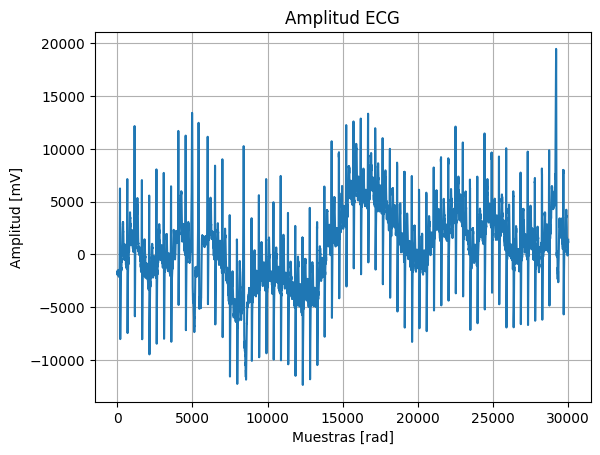

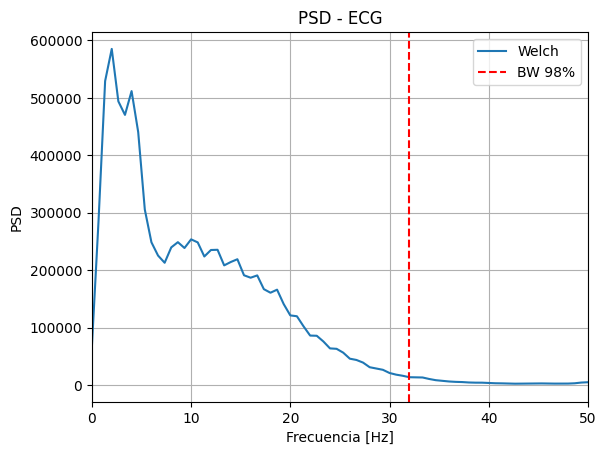

Ancho de banda 98% ECG: 32.00 Hz


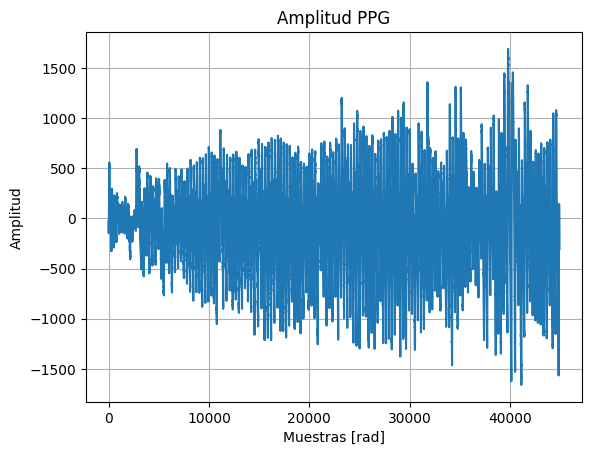

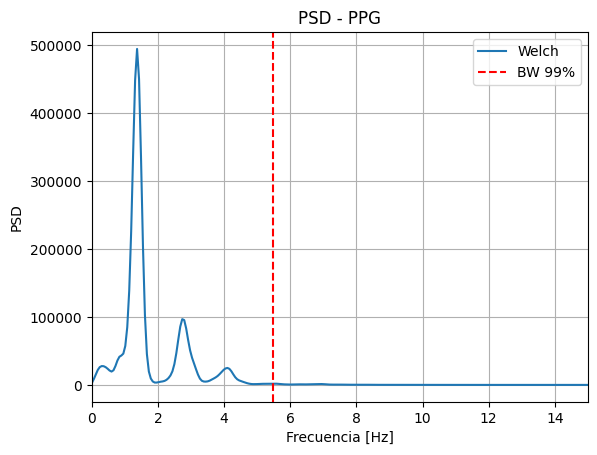

Ancho de banda 99% PPG: 5.46 Hz


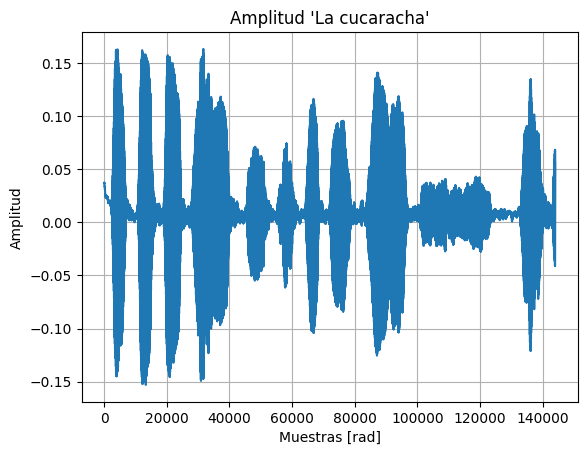

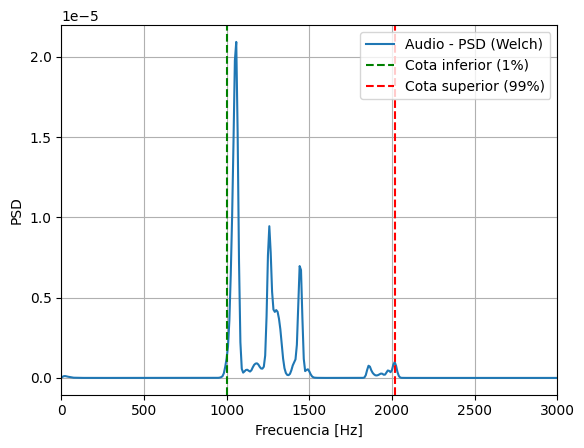

Cota inferior: 1000.00 Hz
Cota superior: 2016.67 Hz
Ancho de banda efectivo 'La cucaracha': 1016.67 Hz


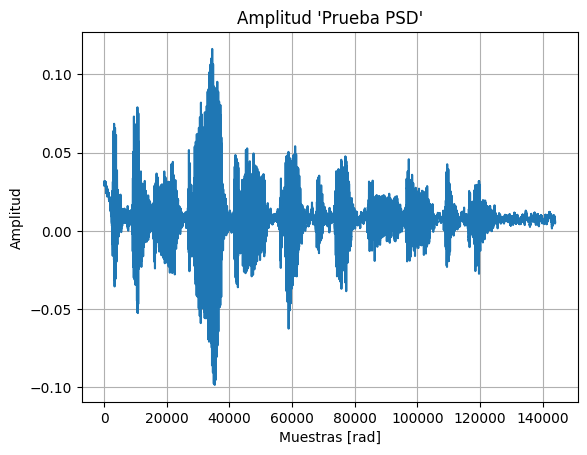

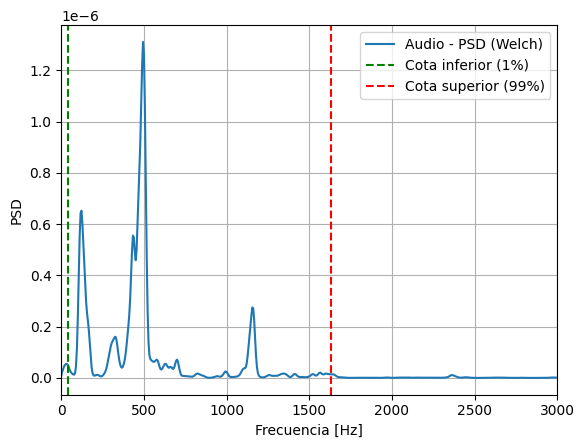

Cota inferior: 38.89 Hz
Cota superior: 1633.33 Hz
Ancho de banda efectivo 'Voz': 1594.44 Hz


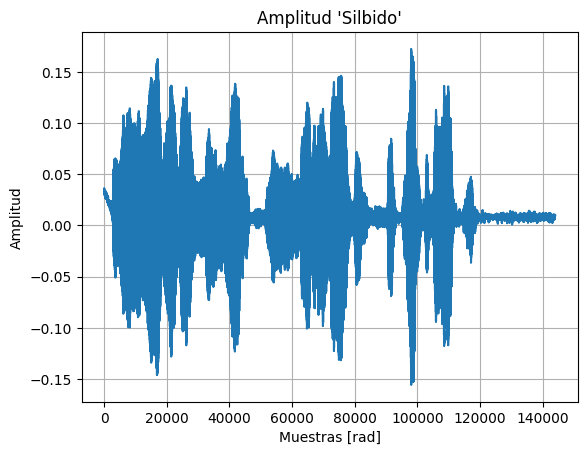

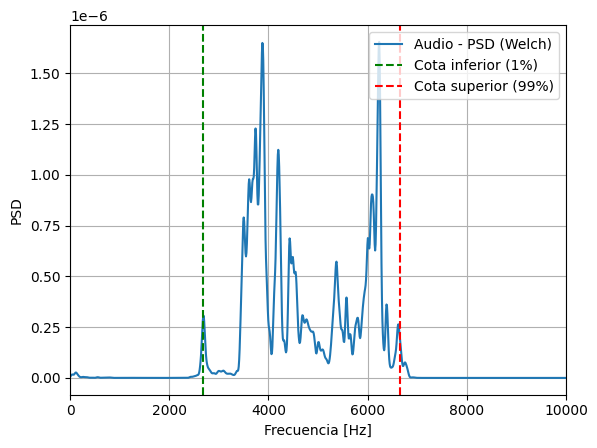

Cota inferior: 2676.85 Hz
Cota superior: 6646.29 Hz
Ancho de banda efectivo 'Silbido': 3969.44 Hz


In [2]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

# Lectura de ECG #

fs_ecg = 1000 # Hz

mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
N = len(ecg_one_lead)

ecg_sucio=ecg_one_lead[670000:700000].reshape(-1) #tomo una parte de 30.000 muestras

plt.figure(1)
plt.plot(ecg_sucio)
plt.title("Amplitud ECG")
plt.xlabel("Muestras [rad]")
plt.ylabel("Amplitud [mV]")
plt.grid()
plt.show()

cant_promedios = 40 #si bajamos el promedio tiene mas varianza y se parece mas a la fft. Mas promedio mas suave, que es lo esperado
nperseg = ecg_sucio.shape[0] // cant_promedios #solo el 0 de la tupla
nfft=2*nperseg
win="hann"

f_ecgS_w, psd_ecgS_w = sig.welch(ecg_sucio, fs=fs_ecg, nperseg=nperseg, window=win, nfft=nfft)

Pcum = np.cumsum(psd_ecgS_w) # potencia acumulada
Pcum = Pcum / Pcum[-1] # normalizo a 1

# ancho de banda 98%
bw = np.where(Pcum >= 0.98)[0][0]
bw_98 = f_ecgS_w[bw] #frecuencia del 98%

plt.figure(2)
plt.plot(f_ecgS_w, psd_ecgS_w, label="Welch")
plt.axvline(bw_98, color="r", linestyle="--", label="BW 98%")
plt.title("PSD - ECG")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.xlim(0, 50)
plt.legend()
plt.grid()
plt.show()

print(f"Ancho de banda 98% ECG: {bw_98:.2f} Hz")

# Lectura de pletismografía (PPG)  #

fs_ppg = 400 # Hz

ppg = np.load('ppg_sin_ruido.npy')

plt.figure(3)
plt.plot(ppg)
plt.title("Amplitud PPG")
plt.xlabel("Muestras [rad]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

cant_promedios = 20 
nperseg = ppg.shape[0] // cant_promedios #solo el 0 de la tupla
nfft=3*nperseg
win="hann"

f_ppg_w, psd_ppg_w = sig.welch(ppg, fs=fs_ppg, nperseg=nperseg, window=win, nfft=nfft)

Pcum2 = np.cumsum(psd_ppg_w)          
Pcum2 = Pcum2 / Pcum2[-1]      

# ancho de banda 99%
bw2 = np.where(Pcum2 >= 0.99)[0][0]
bw2_99 = f_ppg_w[bw2]

plt.figure(4)
plt.clf()
plt.plot(f_ppg_w, psd_ppg_w, label="Welch")
plt.axvline(bw2_99, color="r", linestyle="--", label="BW 99%")
plt.title("PSD - PPG")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.xlim(0, 15)
plt.legend()
plt.grid()
plt.show()

print(f"Ancho de banda 99% PPG: {bw2_99:.2f} Hz")

# Lectura de audio 1#

# Cargar el archivo CSV como un array de NumPy
fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav') 

plt.figure(5)
plt.plot(wav_data)
plt.title("Amplitud 'La cucaracha'")
plt.xlabel("Muestras [rad]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

cant_promedios = 50 
nperseg = wav_data.shape[0] // cant_promedios #solo el 0 de la tupla
nfft=2*nperseg
win="hann"

f_w, psd_w = sig.welch(wav_data, fs_audio, nperseg=nperseg, window=win, nfft=nfft)
#veo senoidales moduladas en amplitud

Pcum3 = np.cumsum(psd_w)     
Pcum3 = Pcum3 / Pcum3[-1]         

low_bw = np.where(Pcum3 >= 0.01)[0][0]
low_freq = f_w[low_bw]

# cota superior (99%)
high_bw = np.where(Pcum3 >= 0.99)[0][0]
high_freq = f_w[high_bw]

bw3 = high_freq - low_freq

plt.figure(6)
plt.plot(f_w, psd_w, label = "Audio - PSD (Welch)")
plt.axvline(low_freq, color="g", linestyle="--", label="Cota inferior (1%)")
plt.axvline(high_freq, color="r", linestyle="--", label="Cota superior (99%)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.xlim(0, 3000)
plt.legend()
plt.grid()
plt.show()

print(f"Cota inferior: {low_freq:.2f} Hz")
print(f"Cota superior: {high_freq:.2f} Hz")
print(f"Ancho de banda efectivo 'La cucaracha': {bw3:.2f} Hz")

# Lectura de audio 2#

# Cargar el archivo CSV como un array de NumPy
fs_audio2, wav_data2 = sio.wavfile.read('prueba psd.wav')

plt.figure(7)
plt.plot(wav_data2)
plt.title("Amplitud 'Prueba PSD'")
plt.xlabel("Muestras [rad]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

cant_promedios = 50 
nperseg = wav_data2.shape[0] // cant_promedios #solo el 0 de la tupla
nfft=3*nperseg
win="hann"

f_w2, psd_w2 = sig.welch(wav_data2, fs_audio2, nperseg=nperseg, window=win, nfft=nfft)
#veo senoidales moduladas en amplitud

Pcum3 = np.cumsum(psd_w2)     
Pcum3 = Pcum3 / Pcum3[-1]         

low_bw = np.where(Pcum3 >= 0.01)[0][0]
low_freq = f_w2[low_bw]

# cota superior (99%)
high_bw = np.where(Pcum3 >= 0.98)[0][0]
high_freq = f_w2[high_bw]

bw3 = high_freq - low_freq

plt.figure(8)
plt.plot(f_w2, psd_w2, label = "Audio - PSD (Welch)")
plt.axvline(low_freq, color="g", linestyle="--", label="Cota inferior (1%)")
plt.axvline(high_freq, color="r", linestyle="--", label="Cota superior (99%)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.xlim(0, 3000)
plt.legend()
plt.grid()
plt.show()

print(f"Cota inferior: {low_freq:.2f} Hz")
print(f"Cota superior: {high_freq:.2f} Hz")
print(f"Ancho de banda efectivo 'Voz': {bw3:.2f} Hz")

# Lectura de audio 3#

# Cargar el archivo CSV como un array de NumPy
fs_audio3, wav_data3 = sio.wavfile.read('silbido.wav')

plt.figure(9)
plt.plot(wav_data3)
plt.title("Amplitud 'Silbido'")
plt.xlabel("Muestras [rad]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

cant_promedios = 110 
nperseg = wav_data2.shape[0] // cant_promedios #solo el 0 de la tupla
nfft=4*nperseg
win="hann"

f_w3, psd_w3 = sig.welch(wav_data3, fs_audio3, nperseg=nperseg, window=win, nfft=nfft)
#veo senoidales moduladas en amplitud

Pcum3 = np.cumsum(psd_w3)     
Pcum3 = Pcum3 / Pcum3[-1]         

low_bw = np.where(Pcum3 >= 0.01)[0][0]
low_freq = f_w3[low_bw]

# cota superior (99%)
high_bw = np.where(Pcum3 >= 0.99)[0][0]
high_freq = f_w3[high_bw]

bw3 = high_freq - low_freq

plt.figure(10)
plt.clf()
plt.plot(f_w3, psd_w3, label = "Audio - PSD (Welch)")
plt.axvline(low_freq, color="g", linestyle="--", label="Cota inferior (1%)")
plt.axvline(high_freq, color="r", linestyle="--", label="Cota superior (99%)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.xlim(0, 10000)
plt.legend()
plt.grid()
plt.show()

print(f"Cota inferior: {low_freq:.2f} Hz")
print(f"Cota superior: {high_freq:.2f} Hz")
print(f"Ancho de banda efectivo 'Silbido': {bw3:.2f} Hz")

El gráfico temporal del ECG muestra una señal con amplitudes variables. Aunque a esta escala temporal no se distinguen claramente los complejos QRS individuales debido al nivel de ruido presente, se observa la naturaleza cuasiperiódica característica de las señales cardíacas. En el espectro estimado mediante el método de Welch, se observa una concentración importante de energía en frecuencias bajas, principalmente entre 0 y 40 Hz, lo que es característico de las señales electrocardiográficas. La densidad espectral decrece rápidamente a medida que aumenta la frecuencia, mostrando que el contenido de alta frecuencia es reducido y corresponde mayormente al ruido o interferencias musculares.
El ancho de banda al 98 % obtenido (30–35 Hz) concuerda con el rango fisiológico esperado para señales ECG, confirmando que la mayor parte de la información relevante se concentra en bajas frecuencias.
Se utilizó el umbral del 98 % porque el ECG presenta un contenido espectral relativamente limpio (a pesar de ser el ruidoso), y un porcentaje ligeramente menor al 99 % permite excluir el ruido de alta frecuencia y centrarse solo en la banda fisiológicamente útil.

En el dominio temporal, la señal PPG muestra oscilaciones periódicas suaves correspondientes a los ciclos de pulso sanguíneo, con amplitud estable. El espectro estimado con el método de Welch evidencia un pico dominante en torno a 1–2 Hz, lo cual coincide con una frecuencia cardíaca aproximada de 60–120 latidos por minuto, típica en reposo. El resto del espectro presenta valores bajos, indicando poca energía en frecuencias más altas.
El ancho de banda del 99% se encuentra alrededor de 4–6 Hz, reflejando que la señal PPG es por naturaleza de banda angosta, dominada por componentes de muy baja frecuencia. Se eligió el 99% porque, al ser una señal suave y de baja frecuencia, incluir casi toda la potencia permite abarcar completamente la variabilidad de la onda pletismográfica sin verse afectada por ruido significativo, que en este caso es mínimo.

La señal temporal de "La cucaracha" presenta variaciones complejas correspondientes a la voz o melodía. El espectro obtenido mediante Welch muestra una distribución de energía amplia, con componentes significativas hasta 2–3 kHz, correspondientes al rango principal de la voz humana. Las cotas del 1 % y 99 % de la potencia acumulada delimitan un ancho de banda efectivo cercano a 1 kHz. En este caso, se usó el 99 % para asegurar que se considere la mayor parte del contenido armónico relevante, ya que las señales de audio suelen tener una distribución de energía más extendida, y un 98 % podría dejar fuera componentes perceptibles en la inteligibilidad o el timbre.

La forma temporal del segundo audio presenta modulaciones en amplitud más pronunciadas. El espectro de Welch muestra picos más definidos en frecuencias concretas, indicando la presencia de componentes tonales destacadas. El ancho de banda efectivo (2 kHz) es similar al del caso anterior, reflejando un contenido típico de voz o tono grabado. En este caso, también se utilizó el 98 % para estimar el ancho de banda, buscando eliminar pequeñas colas espectrales de ruido que no aportan información relevante, sin perder los armónicos principales de la señal. En la práctica, el ancho de banda efectivo utilizado en aplicaciones de voz, como la telefonía, es de aproximadamente 3 kHz (300-3400 Hz). El valor obtenido experimentalmente es similar a este estándar, y captura la región crítica donde se concentra la mayor parte de la información fonética.

La señal temporal del silbido presenta una forma cercana a la sinusoidal, correspondiente a un tono sostenido con variaciones de pitch. El espectro muestra componentes concentradas entre 3 kHz y 6 kHz, con un ancho de banda efectivo de 3 kHz al 99%. Este ancho de banda amplio refleja las variaciones de frecuencia a lo largo del tiempo, no múltiples componentes simultáneas como en la voz. Al promediar los espectros de todos los segmentos, el método de Welch integra todas las frecuencias recorridas por el silbido, dando apariencia de un espectro ancho. En realidad, en cada instante el silbido tiene un ancho de banda muy estrecho, característico de tonos puros que varían temporalmente, a diferencia de la voz que contiene múltiples frecuencias simultáneas. Se empleó el 99 % para capturar toda la potencia de las componentes principales del tono y posibles armónicos leves, sin excluir parte de la energía que define la pureza y el timbre del silbido.

# Conclusiones

El análisis comparativo entre las señales estudiadas evidencia diferencias fundamentales no solo en el ancho de banda efectivo, sino también en la estructura y distribución de la energía espectral. Las señales biomédicas (ECG y PPG) se caracterizan por anchos de banda estrechos (del orden de pocas decenas de Hz), distribución monotónica decreciente de la energía, y alta densidad espectral en su banda útil, lo que las hace particularmente susceptibles a interferencias dentro de su rango de frecuencias. En contraste, las señales acústicas presentan anchos de banda significativamente mayores (del orden de kHz), con estructura espectral compleja y multipico en el caso de la voz, o altamente selectiva en frecuencia para los silbidos.

Las dos señales biomédicas analizadas presentan anchos de banda muy diferentes: el ECG mostró un ancho de banda aproximadamente 6 veces mayor que la PPG. Esta diferencia refleja la naturaleza de los fenómenos fisiológicos registrados.
El ECG mide la actividad eléctrica del corazón, capturando despolarizaciones rápidas y abruptas del miocardio que requieren componentes de frecuencia relativamente altas para representarlas correctamente. Además, al provenir de una prueba de esfuerzo, incorpora artefactos que amplían el espectro, justificando el uso del 98% para excluir ruido de alta frecuencia sin perder información relevante.
La PPG, en cambio, mide variaciones de volumen sanguíneo mediante técnicas ópticas. Su componente fundamental se encuentra alrededor de 1-2 Hz (frecuencia cardíaca típica en reposo). Al ser registrada en reposo permite usar el 99% sin incorporar ruido significativo.


El silbido de la canción "La Cucaracha" presenta energía concentrada en una banda relativamente estrecha en el rango medio (aproximadamente 1-2 kHz), sin componentes significativas por debajo de 1 kHz, lo cual es característico de la producción de silbidos humanos.
Por el contrario, el audio de voz muestra un espectro más rico y distribuido en frecuencias, comenzando desde frecuencias muy bajas (decenas de Hz) y extendiéndose hasta el rango medio (por encima de 1.5 kHz), donde se ubican las frecuencias necesarias para la comprensión del habla. 
Mientras que el silbido es esencialmente un tono puro que varía en frecuencia a lo largo del tiempo, la voz contiene múltiples frecuencias de forma simultánea que coexisten en cada instante.
En el caso del silbido modulado y la canción "La Cucaracha", aunque ambos corresponden a silbidos, presentan anchos de banda con una diferencia de aproximadamente 4 veces. Esta diferencia se explica principalmente porque el silbido modulado recorre un rango de frecuencias mucho más amplio, mientras que "La Cucaracha" se mantiene en un registro más limitado y concentrado.